# Deformable convolutional networks

https://arxiv.org/pdf/1703.06211.pdf

https://github.com/chengdazhi/Deformable-Convolution-V2-PyTorch  

https://deep-learning-study.tistory.com/575  

## translation invariance?

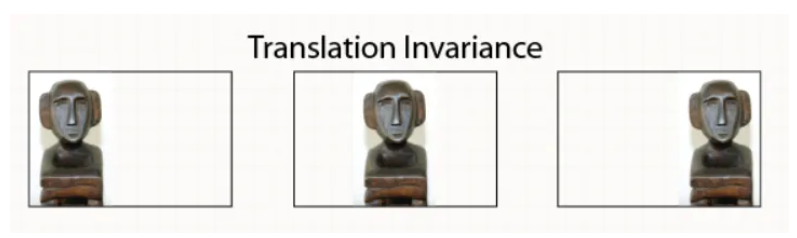

CNN 에서 translation invariance 는 input 의 위치가 변하더라도 output은 그대로 유지되어 변하지 않는다는 의미.  

Max pooling, weight sharing, softmax 를 이용하는 CNN은 이러한  translation invariance 를 가지는데 classification 과 달리 위치변화가 중요한 object detection, image segmentation 과 같은 task의 경우 안좋은 영향을 줄 수 있음.  

따라서 고정된 수용 영역에서 패턴을 학습하지 않고 더 유연한 영역에서 특징을 추출하는 deformable 방법을 제안

## Deformable convolution networks

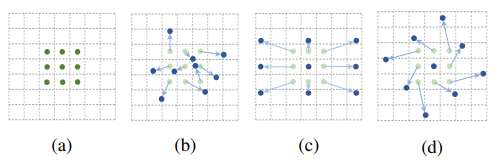

(a) : 기존 convolution  
(b), (c), (d) : deformable convolution  

기존의 convolution 과 달리 수용 영역을 더 유연하게 가짐으로써 객체의 크기나 위치에 강건,  
object detection, segmentation 에서 좋은 성능을 가질 수 있음

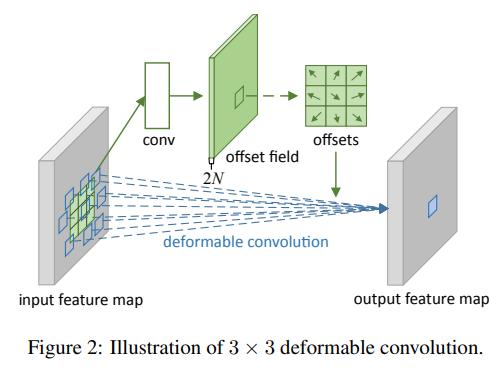

Deformable convolution 은 크게 두 단계로 나뉜다.  

1. convolution layer 를 통해 offset을 계산  
2. 계산된 offset을 이용하여 deformable convolution 수행  





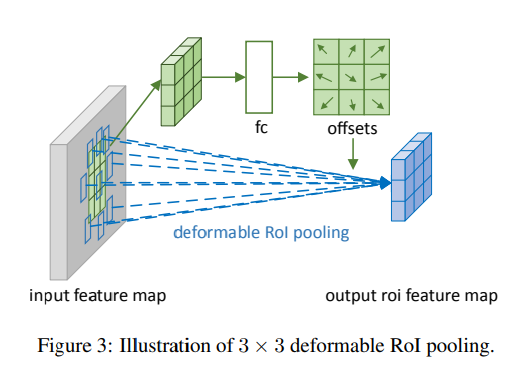

Deformable RoI Pooling 또한 위와 비슷하게  

그리드를 나눠 평균, 최대를 취하는것이 아닌 offset을 이용하여 영역을 확장한 후 pooling 연산을 수행  

먼저 RoI pooling으로 feature map을 얻어 fc를 통해 offset 을 계산 후, 이 offset을 이용하여 deformable RoI pooling 연산 수행.  

deformable convolution 과 달리 offset 계산 시 fc를 사용하는 이유는 기존 RoI pooling과 달리 offset (위치변환)의 정보를 이용하기 때문이다.  
즉, RoI 내부 feature map의 크기가 일정하지 않을 수 있기 때문에 fc를 사용한다.


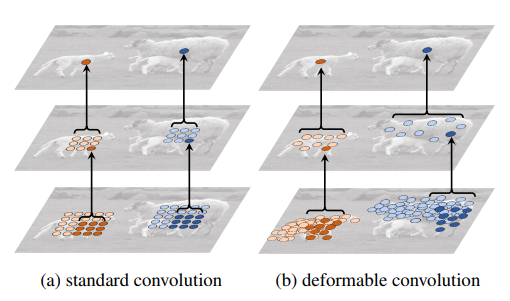

deformable convolution 사용 시 object 에 따라 receptive field 가 달라짐

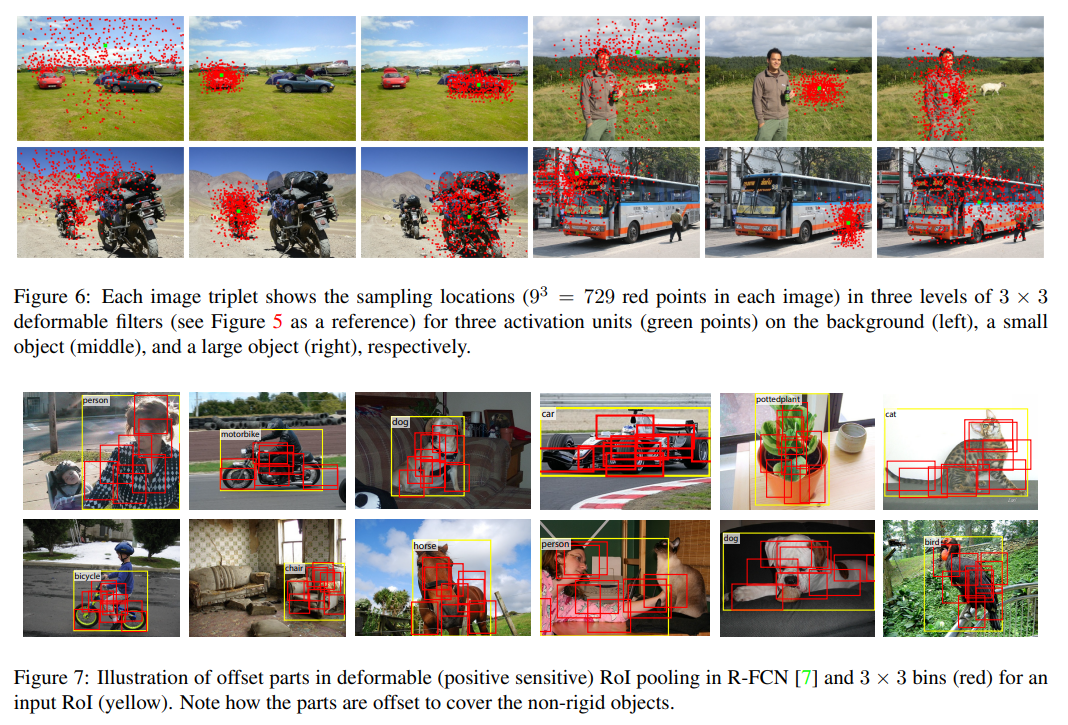

deformable 을 통해 기존의 convolution 보다 성능이 향상됨을 확인.

# 실습

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.utils import make_grid

import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### OxfordIIITPet

In [ ]:
img_size = 128
batch_size = 128

dataset = datasets.OxfordIIITPet('./', download=True,
                                 split='trainval', target_types='segmentation',
                                 transform = transforms.Compose([transforms.Resize(img_size),
                                                                 transforms.CenterCrop(img_size),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize([0.5,0.5,0.5,],
                                                                                      [0.5,0.5,0.5,])]),
                                 target_transform = transforms.Compose([transforms.Resize(img_size),
                                                                        transforms.CenterCrop(img_size),
                                                                        transforms.Lambda(lambda x : torch.tensor(np.array(x))-1 )]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

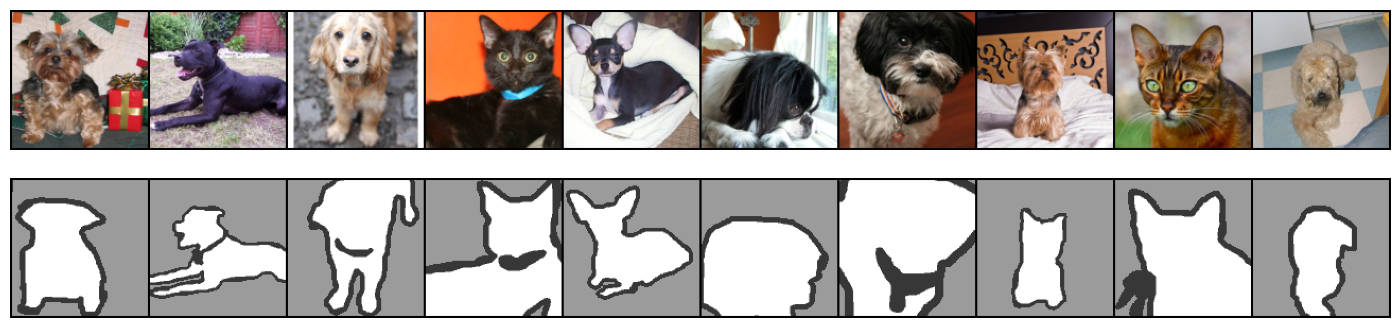

In [ ]:
imgs, segs = next(iter(dataloader))
fig,axes = plt.subplots(2,1, figsize=(20,4))
axes[0].axis('off')
axes[0].imshow(np.transpose(make_grid(imgs[:10], nrow=10, padding=2, normalize=True), (1,2,0)))
axes[1].axis('off')
axes[1].imshow(np.transpose(make_grid(255-100*segs[:10].unsqueeze(1),nrow=10, padding=2), (1,2,0)))
fig.show()

### VOC

In [4]:
import random
voc = datasets.VOCSegmentation('/content/voc', '2012', 'train', True,
                               transform=None,
                               target_transform=None)

class VOCdataset(Dataset):
  def __init__(self, dataset = voc, num_classes=21, img_size=256):
    super(VOCdataset, self).__init__()
    self.dataset = dataset
    self.len = len(dataset)
    self.nc = num_classes
    self.size = img_size
    self.augmentation = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size),
        transforms.RandomHorizontalFlip()
        ])
    self.img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])        
    ])
    self.target_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
  def img_aug(self, img, seg):
    seed = np.random.randint(2147483647)
    random.seed(seed)
    torch.manual_seed(seed)
    img = self.augmentation(img)
    random.seed(seed)
    torch.manual_seed(seed)
    seg = self.augmentation(seg)
    return img, seg

  def __getitem__(self, index):
    img, seg = self.dataset[index]
    img, seg = self.img_aug(img, seg)
    seg = np.array(seg)
    mask = np.zeros((self.size, self.size, self.nc))
    for cls in range(21):
      mask[:,:,cls] = seg==cls
    return self.img_transform(img), self.target_transform(mask)

  def __len__(self):
    return self.len

img_size = 256
batch_size = 64

dataset = VOCdataset(img_size=img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Using downloaded and verified file: /content/voc/VOCtrainval_11-May-2012.tar
Extracting /content/voc/VOCtrainval_11-May-2012.tar to /content/voc


In [5]:
len(dataset)

1464

### Load torchvision FCN_ResNet101

In [ ]:
from torchvision import models
from torchvision.models.segmentation import FCN_ResNet101_Weights

fcn = models.segmentation.fcn_resnet101(weights = FCN_ResNet101_Weights.DEFAULT).eval()

In [ ]:
segs = fcn(imgs)
segs['out'].shape

torch.Size([128, 21, 128, 128])

In [ ]:
om = torch.argmax(segs['out'].squeeze(), dim=1).detach().cpu().numpy()
om.shape

(128, 128, 128)

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

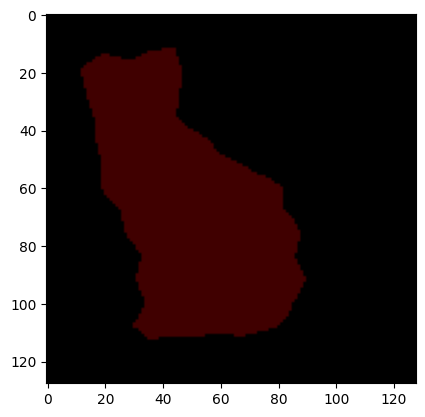

In [ ]:
rgb = decode_segmap(om[0])
plt.imshow(rgb); plt.show()

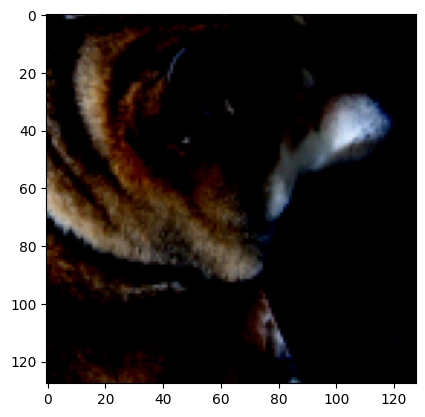

In [ ]:
plt.imshow(np.transpose(imgs[6],(1,2,0)))

In [ ]:
print(fcn)

### FCN 구현

In [ ]:
class FCN(nn.Module):
  def __init__(self, hidden, nc=21):
    super(FCN, self).__init__()
    self.conv1 = nn.Conv2d(3, hidden, 3, 1, 1)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(hidden)
    self.maxpool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(hidden, 2*hidden, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(2*hidden)
    
    self.conv3 = nn.Conv2d(2*hidden, 4*hidden, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(4*hidden)
    
    self.conv4 = nn.Conv2d(4*hidden, 6*hidden, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(6*hidden)
    
    self.conv5 = nn.Conv2d(6*hidden, 6*hidden, 3, 1, 1)
    self.bn5 = nn.BatchNorm2d(6*hidden)
    
    self.conv6 = nn.Conv2d(6*hidden, 6*hidden, 3, 1, 1)
    self.bn6 = nn.BatchNorm2d(6*hidden)
    
    self.conv7 = nn.Conv2d(6*hidden, 8*hidden, 3, 1, 1)
    self.bn7 = nn.BatchNorm2d(8*hidden)

    self.conv8 = nn.Conv2d(8*hidden, nc, 3, 1, 1)
    self.bn8_1 = nn.BatchNorm2d(nc)  
    self.cont8 = nn.ConvTranspose2d(nc, nc, 4, 2, 1)
    self.bn8_2 = nn.BatchNorm2d(nc)   

    self.conv9 = nn.Conv2d(nc, nc, 3, 1, 1)
    self.bn9_1 = nn.BatchNorm2d(nc)  
    self.cont9 = nn.ConvTranspose2d(nc, nc, 8, 8, 0)

    self.conv10 = nn.Conv2d(nc, nc, 1, 1, 0)
    
  def forward(self, img):
    x = self.maxpool(self.bn1(self.relu(self.conv1(img))))
    x = self.maxpool(self.bn2(self.relu(self.conv2(x))))
    x = self.maxpool(self.bn3(self.relu(self.conv3(x))))
    x = self.bn4(self.relu(self.conv4(x)))
    x = self.bn5(self.relu(self.conv5(x)))
    x = self.maxpool(self.bn6(self.relu(self.conv6(x))))
    x = self.bn7(self.relu(self.conv7(x)))
    x = self.bn8_2(self.relu(self.cont8(self.bn8_1(self.relu(self.conv8(x))))))
    x = self.relu(self.cont9(self.bn9_1(self.relu(self.conv9(x)))))
    seg = self.conv10(x)
    return seg

def PA(preds, segs):
  _, preds = preds.max(dim=1)
  _, segs = segs.max(dim=1)
  # preds and segs : B x H x W
  b,h,w = preds.size()
  acc = preds.eq(segs).sum().item() / (b*h*w)
  return acc

def IoU(preds, segs):
  _, preds = preds.max(dim=1)
  _, segs = segs.max(dim=1)
  # preds and segs : B x H x W
  IoUs = []
  for cls in range(1,21):
    preds_mask = torch.where(preds==cls, 1, 0)
    segs_mask = torch.where(segs==cls, 1, 0)
    iou = torch.sum(torch.logical_and(preds_mask, segs_mask), dim=(1,2)) \
    / (torch.sum(torch.logical_or(preds_mask, segs_mask), dim=(1,2)) + 1e-6)
    IoUs.append(iou.sum().item())
  return sum(IoUs)/20, IoUs

In [ ]:
# training 

lr = 0.02
momentum = 0.99

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(hidden=64, nc=21).to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum)
criterion = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
# model load


model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/FCN100voc'))

<All keys matched successfully>

In [ ]:
# training 50 epochs

n_epochs = 5
train_step = 1
print_interval = 50

for epoch in range(n_epochs):
  loss_epoch = 0
  PA_epoch = 0
  IoU_epoch = 0
  for imgs, segs in dataloader:
    imgs, segs = imgs.to(device), segs.to(device).type(torch.float)
    optimizer.zero_grad()    
    preds = model(imgs)
    loss = criterion(preds, segs)
    loss.backward()
    optimizer.step()

    train_step += 1
    loss_epoch += loss.item()
    PA_epoch += PA(preds, segs)
    iou, ious = IoU(preds, segs)
    IoU_epoch += iou
    
  if train_step % print_interval == 0:
    print("[Epoch %2d] [Step %5d] [Loss %.4f] [PA %.2f] [IoU %.2f]"%(
            epoch+1, train_step, loss_epoch/len(dataloader),
            PA_epoch/len(dataloader), IoU_epoch/len(dataloader)))
    print(ious)
    print()

In [ ]:
# save

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/FCN100voc')

### DFCN 구현

In [ ]:
import torchvision.ops as ops

class DeformableConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
      super(DeformableConv, self).__init__()
      self.offset_conv = nn.Conv2d(in_channels, kernel_size * kernel_size * 2, kernel_size=3, stride=1, padding=1, bias=True)
      self.conv = ops.DeformConv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
      
  def forward(self, x):
      offset = self.offset_conv(x)
      x = self.conv(x, offset)
      return x

class DFCN(nn.Module):
  def __init__(self, hidden=32,model=fcn50):
    super(DFCN, self).__init__()
    self.fcn = model
    #self.fcn.conv8 = DeformableConv(8*hidden, 3, 3, 1, 1)
    self.fcn.conv9 = DeformableConv(3, 3, 3, 1, 1)
  def forward(self, x):
    return self.fcn(x)

In [ ]:
lr = 0.02
momentum = 0.99

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DFCN(32, fcn50).to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum)
criterion = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
# training 40 epochs

n_epochs = 40
train_step = 0
print_interval = 50

for epoch in range(n_epochs):
  loss_epoch = 0
  PA_epoch = 0
  IoU_epoch = 0
  for imgs, segs in dataloader:
    imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
    optimizer.zero_grad()    
    preds = model(imgs)
    loss = criterion(preds, segs)
    loss.backward()
    optimizer.step()

    train_step += 1
    loss_epoch += loss.item()
    PA_epoch += PA(preds, segs)
    IoU_epoch += IoU(preds, segs)

  print("[Epoch %2d] [Step %5d] [Loss %.4f] [PA %.2f] [IoU %.2f]"%(
          epoch+1, train_step, loss_epoch/len(dataloader),
          PA_epoch/len(dataloader), IoU_epoch/len(dataloader)))

In [ ]:
# save

torch.save(model.state_dict(), 
           '/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/DFCN40')

### inference

In [ ]:
# test_dataset = datasets.OxfordIIITPet('./', download=True,
#                                  split='test', target_types='segmentation',
#                                  transform = transforms.Compose([transforms.Resize(img_size),
#                                                                  transforms.CenterCrop(img_size),
#                                                                  transforms.ToTensor(),
#                                                                  transforms.Normalize([0.5,0.5,0.5,],
#                                                                                       [0.5,0.5,0.5,])]),
#                                  target_transform = transforms.Compose([transforms.Resize(img_size),
#                                                                         transforms.CenterCrop(img_size),
#                                                                         transforms.Lambda(lambda x : torch.tensor(np.array(x))-1 )]))
# testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

voc_test = datasets.VOCSegmentation('/content/voc', '2012', 'val', True,
                               transform=None,
                               target_transform=None)
testset = VOCdataset(img_size=img_size, dataset=voc_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

Using downloaded and verified file: /content/voc/VOCtrainval_11-May-2012.tar
Extracting /content/voc/VOCtrainval_11-May-2012.tar to /content/voc


In [ ]:
# FCN laod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64

fcn50 = FCN(hidden_size).to(device)
fcn50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/FCN100voc'))

<All keys matched successfully>

In [ ]:
# Deformable laod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 128
hidden_size = 32

dfcn = DFCN(32, fcn50).to(device)
dfcn.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/DFCN40'))

<All keys matched successfully>

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=1)
  return rgb

In [ ]:
decode_segmap(segs[:10].detach().cpu()).shape

(10, 3, 256, 256)

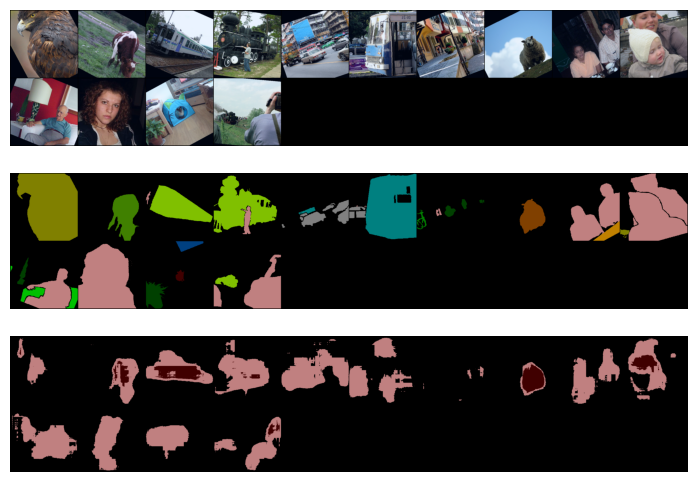

In [ ]:
# with torch.no_grad():
#   imgs, segs = next(iter(testloader))
#   imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
#   preds = fcn50(imgs)
#   _, preds = preds.max(dim=1)
#   print(preds.shape)

#   fig,axes = plt.subplots(4,1, figsize=(20,6))
#   axes[0].axis('off')
#   axes[0].imshow(np.transpose(make_grid(imgs[:14].detach().cpu(), nrow=10, padding=2, normalize=True), (1,2,0)))
#   axes[1].axis('off')
#   axes[1].imshow(np.transpose(make_grid(255-100*segs[:14].detach().cpu().unsqueeze(1),nrow=10, padding=2), (1,2,0)))
#   axes[2].axis('off')
#   axes[2].imshow(np.transpose(make_grid(255-100*preds[:14].detach().cpu().unsqueeze(1),nrow=10, padding=2), (1,2,0)))
#   fig.show()

with torch.no_grad():
  imgs, segs = next(iter(testloader))
  imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
  preds = model(imgs)
  _, preds = preds.max(dim=1)
  _, segs = segs.max(dim=1)

  fig,axes = plt.subplots(3,1, figsize=(20,6))
  axes[0].axis('off')
  axes[0].imshow(np.transpose(make_grid(imgs[:14].detach().cpu(), nrow=10, padding=2, normalize=True), (1,2,0)))
  axes[1].axis('off')
  axes[1].imshow(np.transpose(make_grid(torch.tensor(decode_segmap(segs[:14].detach().cpu())),nrow=10, padding=2), (1,2,0)))
  axes[2].axis('off')
  axes[2].imshow(np.transpose(make_grid(torch.tensor(decode_segmap(preds[:14].detach().cpu())),nrow=10, padding=2), (1,2,0)))
  fig.show()

In [ ]:
np.unique(preds_f.detach().cpu().numpy())

array([ 0,  8, 15])

In [ ]:
with torch.no_grad():
  loss_epoch = 0
  PA_epoch = 0
  IoU_epoch = 0
  fPA_epoch = 0
  fIoU_epoch = 0
  for imgs, segs in testloader:
    imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
    preds_f = fcn50(imgs)
    preds = dfcn(imgs)
    fPA_epoch += PA(preds_f, segs)
    fIoU_epoch += IoU(preds_f, segs)
    PA_epoch += PA(preds, segs)
    IoU_epoch += IoU(preds, segs)

print('PA (standard)  :', fPA_epoch / len(testloader))
print('PA (deformable):', PA_epoch / len(testloader))
print('IoU (standard)  :', fIoU_epoch / len(testloader))
print('IoU (deformable):', IoU_epoch / len(testloader))

PA (standard)  : 0.807373146304736
PA (deformable): 0.7983992323188704
IoU (standard)  : 0.7108528531830887
IoU (deformable): 0.6942686068600622
